# **<center> Final Project**
## <center> Merging the Data and Storing in a Database/Visualizing Data

<center> DSC-540

<center> Kalyan Pothineni

## Dataset -1 - Cleaning/Formatting Flat File Source

In [1]:
#import libraries as needed
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

# Get the flat file
file1 = 'Value_of_Production_E_All_Data.csv'
file2 = 'Value_of_Production_E_AreaCodes.csv'
file3 = 'Value_of_Production_E_Flags.csv'
file4 = 'Value_of_Production_E_ItemCodes.csv'

# Load the flat files into pandas DataFrames
all_data = pd.read_csv(file1, encoding='latin-1')
area_codes = pd.read_csv(file2, encoding='latin-1')
flags = pd.read_csv(file3, encoding='latin-1')
itemcodes = pd.read_csv(file4, encoding='latin-1')

# Specify the desired area codes (North and South America's)
desired_area_codes = [5200, 5204, 5203, 5207, 231]

# Filter the DataFrame with the specified area codes, to limit the sample to North and South America's
all_data = all_data[all_data['Area Code'].isin(desired_area_codes)]

# Check the data in area codes
area_codes = area_codes[area_codes['Area Code'].isin(desired_area_codes)]

# Rename columns by replacing spaces with underscores
all_data = all_data.rename(columns=lambda x: x.replace(' ', '_'))

# Rename columns in all_data DataFrame
all_data = all_data.rename(columns={'Area_Code_(M49)': 'M49_CODE', 'Item_Code_(CPC)': 'Item_Code_CPC'})

# Rename columns by replacing spaces with underscores in area_codes
area_codes = area_codes.rename(columns=lambda x: x.replace(' ', '_'))

# Rename columns by replacing spaces with underscores in itemcodes
itemcodes = itemcodes.rename(columns=lambda x: x.replace(' ', '_'))

# Rename all the columns in all Dataframes to upper case
all_data.rename(columns=lambda x: x.upper(), inplace=True)
itemcodes.rename(columns=lambda x: x.upper(), inplace=True)
area_codes.rename(columns=lambda x: x.upper(), inplace=True)
flags.rename(columns=lambda x: x.upper(), inplace=True)

# Format data into a more readable format
formatted_all_data = all_data.style.format({
    'Value': '{:,.2f}',  # Format 'Value' column as comma-separated float with 2 decimal places
    'Area': lambda x: x.upper()  # Convert 'Area' column values to uppercase
})

# Convert 'Value' column to numeric
all_data['Value'] = pd.to_numeric(all_data['VALUE'])

# Calculate z-scores
all_data['z_score'] = np.abs(stats.zscore(all_data['VALUE']))

# Set a threshold for identifying outliers
threshold = 1

# Filter out rows with z-scores exceeding the threshold
outliers = all_data[all_data['z_score'] > threshold]
print("Number of rows:", all_data.shape[0])
print("Number of outliers:", outliers.shape[0])

# Remove outliers from the DataFrame
all_data = all_data[all_data['z_score'] <= threshold]
print("Number of rows after removing outliers:", all_data.shape[0])

# Clean the missing values
# Count Missing Values
missing_values = all_data.isnull()
missing_counts = missing_values.sum(axis=1)

# Filter Rows with Missing Values
mask = missing_counts > 0
rows_with_missing = all_data[mask]

# Delete Rows with Missing Values
all_data = all_data.dropna()

print("Number of rows after dropping missing values:", all_data.shape[0])

# Fix casing in all_data in 'AREA', 'ITEM', 'ELEMENT', and 'FLAG' columns by converting all values to title case
all_data['AREA'] = all_data['AREA'].str.title()
all_data['ITEM'] = all_data['ITEM'].str.title()
all_data['ELEMENT'] = all_data['ELEMENT'].str.title()
all_data['FLAG'] = all_data['FLAG'].str.title()

# Fix casing in all_data in 'ITEM' column by converting all values to title case
itemcodes['ITEM'] = itemcodes['ITEM'].str.title()

# Fix casing in area_codes in 'AREA' column by converting all values to title case
area_codes['AREA'] = area_codes['AREA'].str.title()

# Remove single quote in M49_CODE column in all_data
all_data['M49_CODE'] = all_data['M49_CODE'].str.replace("'", "")

# Remove single quote in M49_CODE column in area_codes
area_codes['M49_CODE'] = area_codes['M49_CODE'].str.replace("'", "")


Number of rows: 114327
Number of outliers: 4508
Number of rows after removing outliers: 109819
Number of rows after dropping missing values: 109819


In [2]:
# Insert into sqlite db, for this exercise lets use production_data db
import sqlite3

# Connect to the SQLite database
conn = sqlite3.connect('production_data.db')

# Rename the "Value" column to something else
all_data = all_data.rename(columns={'Value': 'Production_Value'})

# Load the modified DataFrame into the database
all_data.to_sql('all_data', conn, index=False, if_exists='replace')
area_codes.to_sql('area_codes', conn, index=False, if_exists='replace')
itemcodes.to_sql('itemcodes', conn, index=False, if_exists='replace')
flags.to_sql('flags', conn, index=False, if_exists='replace')

# Close the database connection
conn.close()

print("DataFrames loaded into the SQLite database.")


DataFrames loaded into the SQLite database.


## Dataset-2 - Cleaning/Formatting Website Data

In [3]:
# Import Libraries as needed
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
from fuzzywuzzy import fuzz, process
import matplotlib.pyplot as plt

# UN data from FAOSTAT for North America
na_url = "http://data.un.org/en/reg/g21.html"
na_response = requests.get(na_url)

# Check if the request was successful
if na_response.status_code == 200:
    na_html_content = na_response.text
else:
    print("Failed to retrieve the webpage.")
    exit()
    
na_soup = BeautifulSoup(na_html_content, "html.parser")

# Find the table element that contains the data
na_table = na_soup.find("table", class_="pure-table")

# Initialize empty lists to store the data
data = []

# Extract the data from the table rows
na_rows = na_table.find_all("tr")
for row in na_rows:
    # Assuming each row has data in "td" elements, modify accordingly if the structure is different
    cols = row.find_all("td")
    row_data = [col.text.strip() for col in cols]
    data.append(row_data)

# Convert the data into a DataFrame
na_df = pd.DataFrame(data)

# Optionally, you can set the first row as the column headers
na_df.columns = na_df.iloc[0]
na_df = na_df[1:]

# Drop duplicate rows based on all columns
na_df = na_df.drop_duplicates()

# Find the table element within the "Economic indicators" section
na_section_title = na_soup.find('summary', text='Economic indicators')
na_economic_table = na_section_title.find_next('table', class_='pure-table')

# Initialize empty lists to store the data
data = []
headers = []

# Extract the data from the table rows
rows = na_economic_table.find('tbody').find_all('tr')

# Use regular expressions to extract the "Economic indicators" section
na_economic_section = re.search(r'<summary>Economic indicators</summary>.*?</table>', na_html_content, re.DOTALL)
if not na_economic_section:
    print("Economic indicators section not found.")
    exit()

# Extract the table content from the economic section
na_table_content = na_economic_section.group()

# Read the table using pandas
na_eco_ind_df = pd.read_html(na_table_content)[0]

# Clean up the DataFrame
na_eco_ind_df = na_eco_ind_df.dropna(axis=1, how='all').dropna(axis=0, how='all').reset_index(drop=True)

# Use regular expressions to extract the "Social indicators" section
na_social_indicators = re.search(r'<summary>Social indicators</summary>.*?</table>', na_html_content, re.DOTALL)
if not na_social_indicators:
    print("Social indicators section not found.")
    exit()

# Extract the table content from the economic section
na_table_content_soc = na_social_indicators.group()

# Read the table using pandas
na_soc_ind_df = pd.read_html(na_table_content_soc)[0]

# Clean up the DataFrame
na_soc_ind_df = na_soc_ind_df.dropna(axis=1, how='all').dropna(axis=0, how='all').reset_index(drop=True)

# Use regular expressions to extract the "Environment and infrastructure indicators" section
na_env_indicators = re.search(r'<summary>Environment and infrastructure indicators</summary>.*?</table>', na_html_content, re.DOTALL)
if not na_env_indicators:
    print("Environment and infrastructure indicators section not found.")
    exit()

# Extract the table content from the economic section
na_table_content_env = na_env_indicators.group()

# Read the table using pandas
na_env_ind_df = pd.read_html(na_table_content_env)[0]

# Clean up the DataFrame
na_env_ind_df = na_env_ind_df.dropna(axis=1, how='all').dropna(axis=0, how='all').reset_index(drop=True)

# Define the dictionary to rename the column(s)
new_column_names = {'Unnamed: 0': 'Economic Info'}

# Rename the column(s) using the rename() method for Economic Indicators
na_eco_ind_df.rename(columns=new_column_names, inplace=True)

# Define the dictionary to rename the column(s)
new_column_names_01 = {'Unnamed: 0': 'Social info'}

# Rename the column(s) using the rename() method for Social Indicators
na_soc_ind_df.rename(columns=new_column_names_01, inplace=True)

# Define the dictionary to rename the column(s)
new_column_names_02 = {'Unnamed: 0': 'Environmental indicators'}

# Rename the column(s) using the rename() method for Environmental Indicators
na_env_ind_df.rename(columns=new_column_names_02, inplace=True)

# Convert column names to uppercase
na_eco_ind_df.columns = na_eco_ind_df.columns.str.upper()

# Replace spaces with underscores in column names
na_eco_ind_df.columns = na_eco_ind_df.columns.str.replace(' ', '_')

# Convert column names to uppercase (Social)
na_soc_ind_df.columns = na_soc_ind_df.columns.str.upper()

# Replace spaces with underscores in column names
na_soc_ind_df.columns = na_soc_ind_df.columns.str.replace(' ', '_')

# Convert column names to uppercase (Environmental)
na_env_ind_df.columns = na_env_ind_df.columns.str.upper()

# Replace spaces with underscores in column names
na_env_ind_df.columns = na_env_ind_df.columns.str.replace(' ', '_')

# Extract values in brackets using regular expressions and create a new column
na_eco_ind_df['INDICATOR'] = na_eco_ind_df['ECONOMIC_INFO'].str.extract(r'\(([^)]+)\)')

# Remove the values in brackets from the original "ECONOMIC_INFO" column
na_eco_ind_df['ECONOMIC_INFO'] = na_eco_ind_df['ECONOMIC_INFO'].str.replace(r'\([^)]+\)', '', regex=True)

# Remove ",f" from the "ECONOMIC_INFO" column
na_eco_ind_df['ECONOMIC_INFO'] = na_eco_ind_df['ECONOMIC_INFO'].str.replace(r',f', '', regex=False)

# Extract values in brackets using regular expressions and create a new column
na_soc_ind_df['INDICATOR'] = na_soc_ind_df['SOCIAL_INFO'].str.extract(r'\(([^)]+)\)')

# Remove the values in brackets from the original "SOCIAL_INFO" column
na_soc_ind_df['SOCIAL_INFO'] = na_soc_ind_df['SOCIAL_INFO'].str.replace(r'\([^)]+\)', '', regex=True)

# Remove ",f" from the "SOCIAL_INFO" column
na_soc_ind_df['SOCIAL_INFO'] = na_soc_ind_df['SOCIAL_INFO'].str.replace(r',f', '', regex=False)

# Extract values in brackets using regular expressions and create a new column
na_env_ind_df['INDICATOR'] = na_env_ind_df['ENVIRONMENTAL_INDICATORS'].str.extract(r'\(([^)]+)\)')

# Remove the values in brackets from the original "ENVIRONMENTAL_INDICATORS" column
na_env_ind_df['ENVIRONMENTAL_INDICATORS'] = na_env_ind_df['ENVIRONMENTAL_INDICATORS'].str.replace(r'\([^)]+\)', '', regex=True)

# Remove ",f" from the "ENVIRONMENTAL_INDICATORS" column
na_env_ind_df['ENVIRONMENTAL_INDICATORS'] = na_env_ind_df['ENVIRONMENTAL_INDICATORS'].str.replace(r',f', '', regex=False)

# Find duplicates based on all columns (Ecomonic)
duplicates_eco = na_eco_ind_df.duplicated()

# Filter the DataFrame to show only duplicates
duplicated_rows = na_eco_ind_df[duplicates_eco]

# Find duplicates based on all columns (Social)
duplicates_soc = na_soc_ind_df.duplicated()

# Filter the DataFrame to show only duplicates
duplicated_rows = na_soc_ind_df[duplicates_soc]


# Find duplicates based on all columns (Environmental)
duplicates_env = na_env_ind_df.duplicated()

# Filter the DataFrame to show only duplicates
duplicated_rows = na_env_ind_df[duplicates_env]

# Merge the dataframes using the '2010', '2015', and '2021' columns as keys
merged_df = pd.merge(na_eco_ind_df, na_soc_ind_df, on=['2010', '2015', '2021'], how='outer', suffixes=('_eco', '_soc'))
merged_df = pd.merge(merged_df, na_env_ind_df, on=['2010', '2015', '2021'], how='outer', suffixes=('', '_env'))

# Display the merged dataframe
merged_df.head()

,ECONOMIC_INFO,2010,2015,2021,INDICATOR_eco,SOCIAL_INFO,INDICATOR_soc,ENVIRONMENTAL_INDICATORS,INDICATOR
0,GDP: Gross domestic product,16 618 456,19 803 583,23 185 108b,million current US$,NaN,NaN,NaN,NaN
1,GDP growth rate,2.6,2.9,2.1b,"annual %, const. 2015 prices",NaN,NaN,NaN,NaN
2,GDP per capita,48 410.6,55 468.3,63 244.4b,current US$,NaN,NaN,NaN,NaN
3,Employment in agricultured,1.5,1.5,1.3e,% of employed,NaN,NaN,NaN,NaN
4,Employment in industryd,19.7,19.9,19.7e,% of employed,NaN,NaN,NaN,NaN


In [4]:
# Connect to the SQLite database
conn = sqlite3.connect('production_data.db')

# Load the merged DataFrame into the database
merged_df.to_sql('faostat_of_north_america', conn, index=False, if_exists='replace')

# Close the database connection
conn.close()

print("Processed merged DataFrame loaded into the SQLite database.")

Processed merged DataFrame loaded into the SQLite database.


## Dataset -3 - Connecting to an API/Pulling in the Data and Cleaning/Formatting

In [5]:
# Import the Libraries as needed

import requests
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the API key from the JSON file
with open('kalyanpothineni_APIkey_USDAERS.json') as f:
    api_keys = json.load(f)
    API_KEY = api_keys['USDAERSapikey']
    
# Function to fetch data from the API
def fetch_data(endpoint):
    url = f'https://api.ers.usda.gov/data/arms/{endpoint}?api_key={API_KEY}'
    response = requests.get(url)
    return response.json()

# Function to format data into a DataFrame
def format_data(data):
    if isinstance(data, list):
        # Handle the list of dictionaries structure
        return pd.DataFrame.from_records(data)
    return pd.DataFrame(data)

# Function to replace headers in the DataFrame
def replace_headers(data, new_headers):
    data.columns = new_headers
    
# Fetch data for different endpoints
year_data = fetch_data('year')
state_data = fetch_data('state')

# Extract the list of years from year_data
years = year_data['data']

# Create a DataFrame from the years list
year_df = pd.DataFrame(years, columns=['Year'])

# Replace headers for the year dataset
year_headers = ['YEAR']
replace_headers(year_df, year_headers)

# Extract the list of data from state_data
state = state_data['data']

# Create a DataFrame from the state list
state_df = pd.DataFrame(state)

# Replace headers for the farmtype dataset
state_headers = ['ID', 'STATE_CODE', 'STATE_NAME']
replace_headers(state_df, state_headers)

# Convert 'ID' column to int 
state_df['ID'] = state_df['ID'].astype(int)

# Convert 'STATE_CODE' column to uppercase (all caps)
state_df['STATE_CODE'] = state_df['STATE_CODE'].str.upper()

# Fetch data from the API for survey data
url = f'https://api.ers.usda.gov/data/arms/surveydata?api_key={API_KEY}&year=2015,2016&state=all&report=income+statement'
response = requests.get(url)

if response.status_code == 200:
    # Connection successful
    survey_data = response.json()
    print("Connection successful. Data fetched successfully.")
    # Do further processing with the fetched data if needed
else:
    print(f"Connection failed. Status code: {response.status_code}")

# Survey Data
# Extract the list of data from survey_data
survey = survey_data['data']

# Create a DataFrame from the state list
survey_df = pd.DataFrame(survey)

# Convert all column names to uppercase
survey_df.rename(columns=lambda x: x.upper(), inplace=True)

# Remove spaces in column headers
survey_df.rename(columns=lambda x: x.replace(' ', '_').upper(), inplace=True)

# Trim spaces in column headers
survey_df.rename(columns=lambda x: x.strip(), inplace=True)

# Function to remove outliers using the Z-score method
def remove_outliers_zscore(df, column, z_thresh=3):
    mean = df[column].mean()
    std = df[column].std()
    z_scores = np.abs((df[column] - mean) / std)
    return df[z_scores <= z_thresh]

# Columns where you want to remove outliers (e.g., 'ESTIMATE', 'MEDIAN', 'RSE')
numerical_columns = ['ESTIMATE', 'MEDIAN', 'RSE']

# Remove outliers from the specified numerical columns
for column in numerical_columns:
    survey_df = remove_outliers_zscore(survey_df, column)

# Fixing Casing - Convert 'STATE' column to uppercase
survey_df['STATE'] = survey_df['STATE'].str.upper()

# Standardizing Text - Replace inconsistent values
survey_df['STATE'] = survey_df['STATE'].str.replace('Cali', 'California')
survey_df['STATE'] = survey_df['STATE'].str.replace('Fla', 'Florida')


Connection successful. Data fetched successfully.


In [6]:
# Connect to the SQLite database
conn = sqlite3.connect('production_data.db')

# Load the survey_df DataFrame into the database
survey_df.to_sql('survey_data', conn, index=False, if_exists='replace')

# Close the database connection
conn.close()

print("survey_df loaded into the SQLite database.")

survey_df loaded into the SQLite database.


#### Check the tables loaded, table ddl's and join them by keys

In [7]:
# Connect to the SQLite database
conn = sqlite3.connect('production_data.db')

# Get the list of tables in the database
cursor = conn.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()

# Print the list of table names
for table in tables:
    print(table[0])

# Close the database connection
conn.close()

joined_data
all_data
area_codes
itemcodes
flags
faostat_of_north_america
survey_data


In [8]:
# Connect to the SQLite database
conn = sqlite3.connect('production_data.db')

# Get the list of tables in the database
cursor = conn.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()

# Fetch DDL statements for each table
for table in tables:
    table_name = table[0]
    cursor.execute(f"SELECT sql FROM sqlite_master WHERE type='table' AND name='{table_name}';")
    ddl_statement = cursor.fetchone()[0]
    print(f"Table: {table_name}\nDDL:\n{ddl_statement}\n\n")

# Close the database connection
conn.close()

Table: joined_data
DDL:
CREATE TABLE joined_data(
  AREA_CODE INT,
  M49_CODE TEXT,
  AREA TEXT,
  ITEM_CODE INT,
  ITEM_CODE_CPC TEXT,
  ITEM TEXT,
  ELEMENT_CODE INT,
  ELEMENT TEXT,
  YEAR_CODE INT,
  YEAR INT,
  UNIT TEXT,
  VALUE REAL,
  FLAG TEXT,
  Production_Value REAL,
  z_score REAL,
  AREA_NAME TEXT,
  ITEM_NAME TEXT,
  SURVEY_YEAR INT,
  FARMTYPE TEXT,
  CATEGORY_VALUE TEXT,
  ESTIMATE,
  MEDIAN,
  RSE
)


Table: all_data
DDL:
CREATE TABLE "all_data" (
"AREA_CODE" INTEGER,
  "M49_CODE" TEXT,
  "AREA" TEXT,
  "ITEM_CODE" INTEGER,
  "ITEM_CODE_CPC" TEXT,
  "ITEM" TEXT,
  "ELEMENT_CODE" INTEGER,
  "ELEMENT" TEXT,
  "YEAR_CODE" INTEGER,
  "YEAR" INTEGER,
  "UNIT" TEXT,
  "VALUE" REAL,
  "FLAG" TEXT,
  "Production_Value" REAL,
  "z_score" REAL
)


Table: area_codes
DDL:
CREATE TABLE "area_codes" (
"AREA_CODE" INTEGER,
  "M49_CODE" TEXT,
  "AREA" TEXT
)


Table: itemcodes
DDL:
CREATE TABLE "itemcodes" (
"ITEM_CODE" INTEGER,
  "CPC_CODE" TEXT,
  "ITEM" TEXT
)


Table: flags
DDL:
C

In [9]:
# Drop the table if it exists
# Connect to the SQLite database
conn = sqlite3.connect('production_data.db')

# Create a new table by joining the tables
query = """
DROP TABLE IF EXISTS joined_data;
"""

# Execute the query
conn.execute(query)

# Commit the changes and close the connection
conn.commit()
conn.close()

print("Drop the table if it exists.")


Drop the table if it exists.


In [10]:
# Connect to the SQLite database
conn = sqlite3.connect('production_data.db')

# Create a new table by joining the tables
query = """
CREATE TABLE "joined_data" AS
SELECT
    ad.AREA_CODE, ad.M49_CODE, ad.AREA, ad.ITEM_CODE, ad.ITEM_CODE_CPC, ad.ITEM,
    ad.ELEMENT_CODE, ad.ELEMENT, ad.YEAR_CODE, ad.YEAR, ad.UNIT, ad.VALUE,
    ad.FLAG, ad.Production_Value, ad.z_score,
    ac.AREA as AREA_NAME,
    ic.ITEM as ITEM_NAME,
    s.YEAR as SURVEY_YEAR, s.FARMTYPE, s.CATEGORY_VALUE, s.ESTIMATE, s.MEDIAN, s.RSE
FROM
    all_data ad
LEFT JOIN
    area_codes ac ON ad.AREA_CODE = ac.AREA_CODE
LEFT JOIN
    itemcodes ic ON ad.ITEM_CODE = ic.ITEM_CODE
LEFT JOIN
    (
            SELECT
            YEAR,
            FARMTYPE,
            CATEGORY_VALUE,
            AVG(ESTIMATE) AS ESTIMATE,
            AVG(MEDIAN) AS MEDIAN,
            AVG(RSE) AS RSE
        FROM
            survey_data
        GROUP BY
            YEAR, FARMTYPE, CATEGORY_VALUE
    ) s ON TRIM(ad.YEAR) = TRIM(s.YEAR)
;
"""

# Execute the query
conn.execute(query)

# Commit the changes and close the connection
conn.commit()
conn.close()

print("Tables joined and new table 'joined_data' created.")


Tables joined and new table 'joined_data' created.


In [2]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Connect to the SQLite database
conn = sqlite3.connect('production_data.db')

# Query to retrieve the joined_data from the database
query = "SELECT * FROM joined_data"

# Fetch the data into a DataFrame
joined_data = pd.read_sql(query, conn)

# Close the database connection
conn.close()

print("Dataframe created from table joined_data.")

Dataframe created from table joined_data.


In [25]:
joined_data.head()

,AREA_CODE,M49_CODE,AREA,ITEM_CODE,ITEM_CODE_CPC,ITEM,ELEMENT_CODE,ELEMENT,YEAR_CODE,YEAR,...,Production_Value,z_score,AREA_NAME,ITEM_NAME,SURVEY_YEAR,FARMTYPE,CATEGORY_VALUE,ESTIMATE,MEDIAN,RSE
0,231,840,United States Of America,221,'01371,"Almonds, In Shell",152,Gross Production Value (Constant 2014-2016 Tho...,1961,1961,...,304563.0,0.211375,United States Of America,Almonds; In Shell,NaN,None,None,NaN,NaN,NaN
1,231,840,United States Of America,221,'01371,"Almonds, In Shell",152,Gross Production Value (Constant 2014-2016 Tho...,1962,1962,...,220167.0,0.213390,United States Of America,Almonds; In Shell,NaN,None,None,NaN,NaN,NaN
2,231,840,United States Of America,221,'01371,"Almonds, In Shell",152,Gross Production Value (Constant 2014-2016 Tho...,1963,1963,...,273832.0,0.212108,United States Of America,Almonds; In Shell,NaN,None,None,NaN,NaN,NaN
3,231,840,United States Of America,221,'01371,"Almonds, In Shell",152,Gross Production Value (Constant 2014-2016 Tho...,1964,1964,...,344026.0,0.210432,United States Of America,Almonds; In Shell,NaN,None,None,NaN,NaN,NaN
4,231,840,United States Of America,221,'01371,"Almonds, In Shell",152,Gross Production Value (Constant 2014-2016 Tho...,1965,1965,...,334374.0,0.210663,United States Of America,Almonds; In Shell,NaN,None,None,NaN,NaN,NaN


## Visualization

In [12]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

### Line Plot on average estimates by year from Survey

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


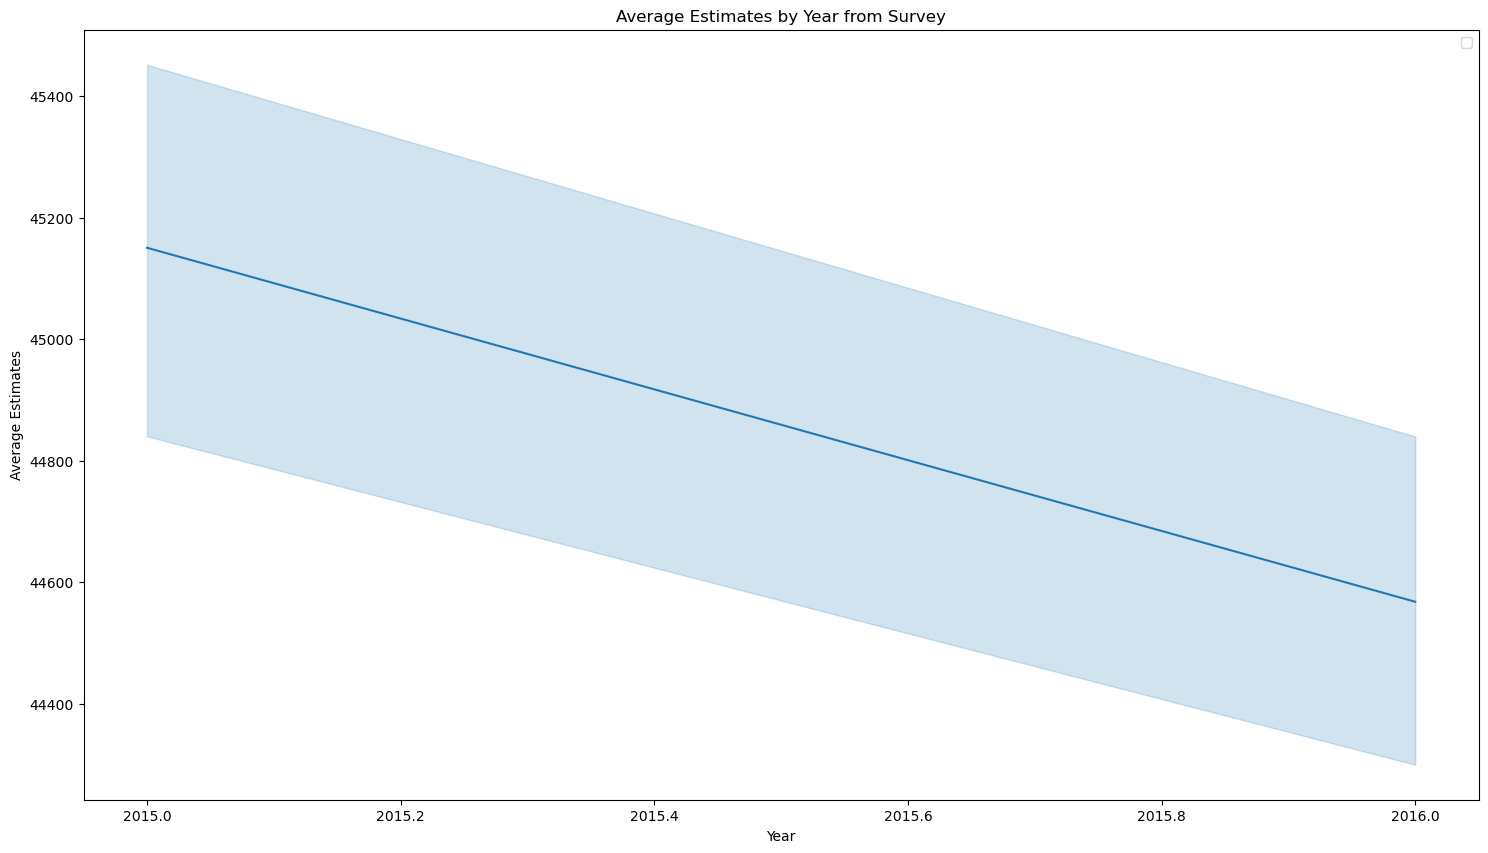

In [13]:
# Line Plot on average estimates by year from Survey
plt.figure(figsize=(18, 10))
sns.lineplot(data=joined_data, x='YEAR', y='ESTIMATE')
plt.title('Average Estimates by Year from Survey')
plt.xlabel('Year')
plt.ylabel('Average Estimates')
plt.legend()
plt.show()

### Barplot on comparison of Meat Income, Categories by state between years 2015 to 2021

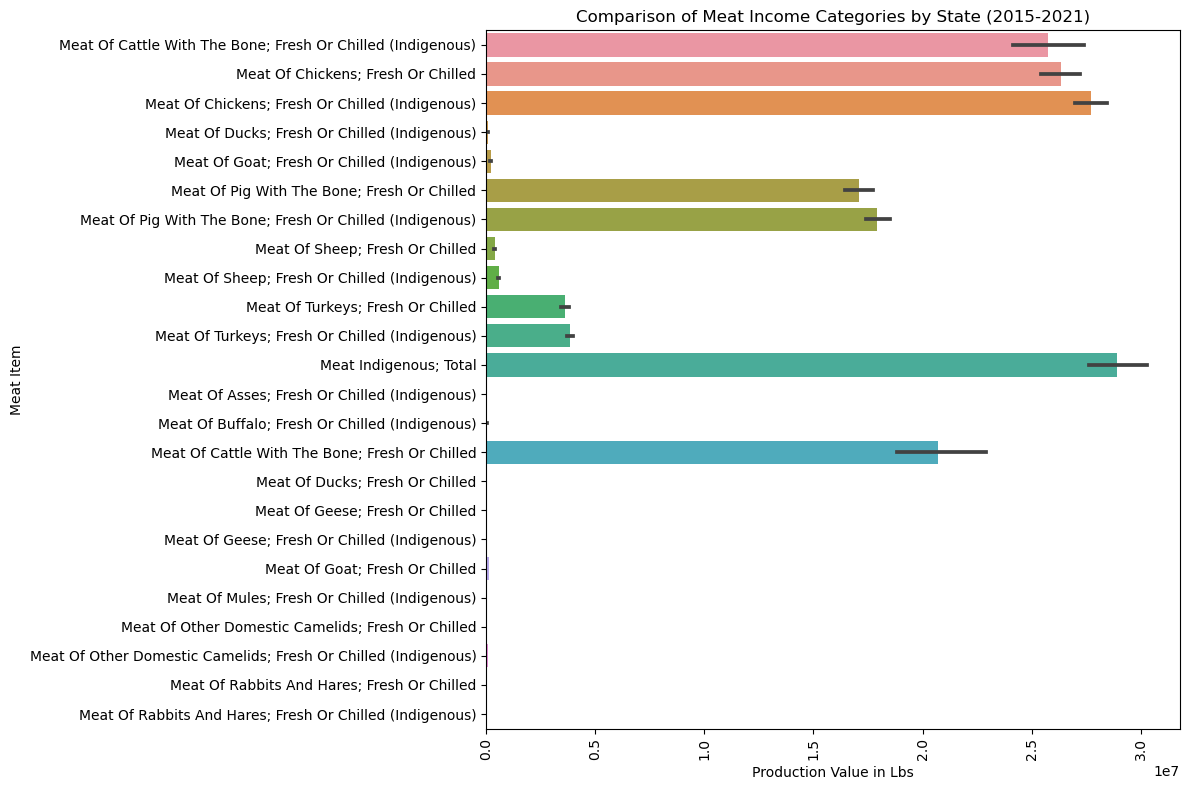

In [14]:
# Filter the joined_data DataFrame for the specified years and items starting with 'Meat'
filtered_data = joined_data[
    (joined_data['YEAR'].between(2015, 2021)) & 
    (joined_data['ITEM_NAME'].str.startswith('Meat'))
]

# Barplot on comparison of Meat Income, Categories by state between years 2015 to 2021
plt.figure(figsize=(12, 8))
sns.barplot(data=filtered_data, x='Production_Value', y='ITEM_NAME')
plt.title('Comparison of Meat Income Categories by State (2015-2021)')
plt.xlabel('Production Value in Lbs')
plt.ylabel('Meat Item')
plt.xticks(rotation=90)  # Rotate x-axis labels by 90 degrees
plt.tight_layout()  # Adjust layout for better spacing
plt.show()

### Barh Chart to find the top items by production value

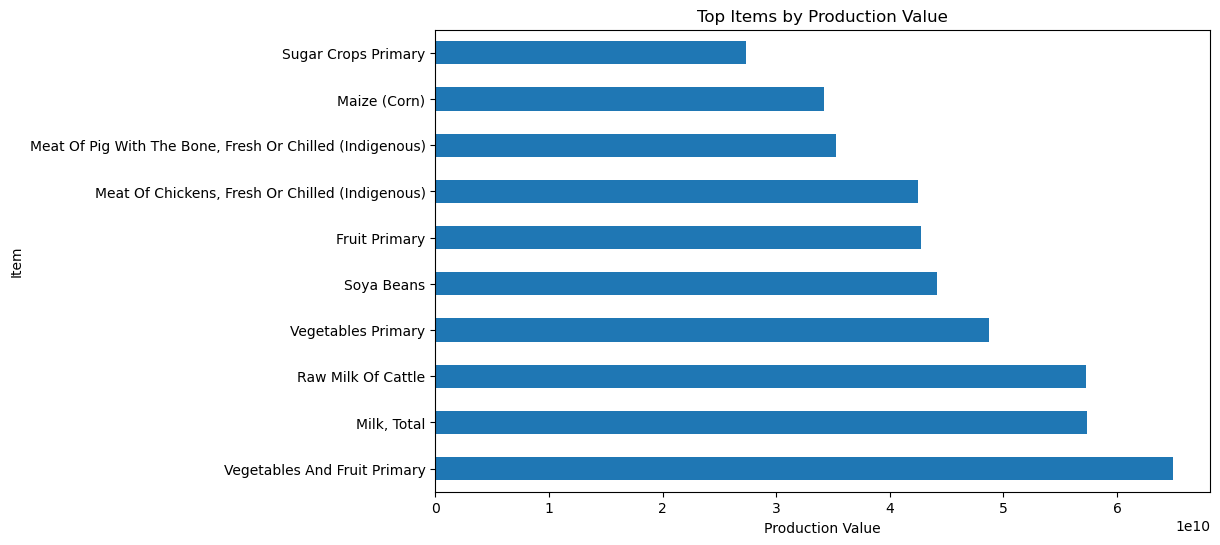

In [15]:
# Barh Chart to find the top items by production value
top_items = joined_data.groupby('ITEM')['Production_Value'].sum().nlargest(10)
plt.figure(figsize=(10, 6))
top_items.plot(kind='barh')
plt.title('Top Items by Production Value')
plt.xlabel('Production Value')
plt.ylabel('Item')
plt.show()

### Scatterplot to find Correlation between Production value and z_score

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


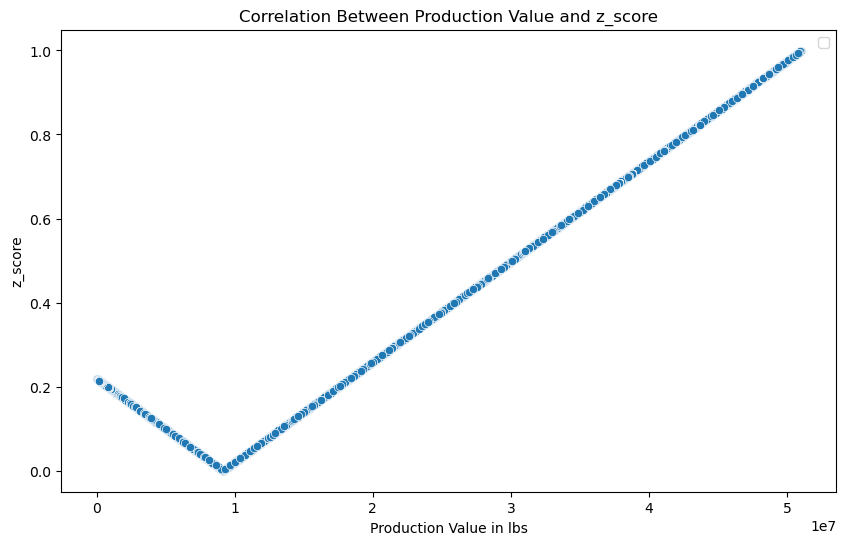

In [16]:
# Scatterplot to find Correlation between Production value and z_score
plt.figure(figsize=(10, 6))
sns.scatterplot(data=joined_data, x='Production_Value', y='z_score')
plt.title('Correlation Between Production Value and z_score')
plt.xlabel('Production Value in lbs')
plt.ylabel('z_score')
plt.legend()
plt.show()


### Bar Plot of Average Production Value by Element

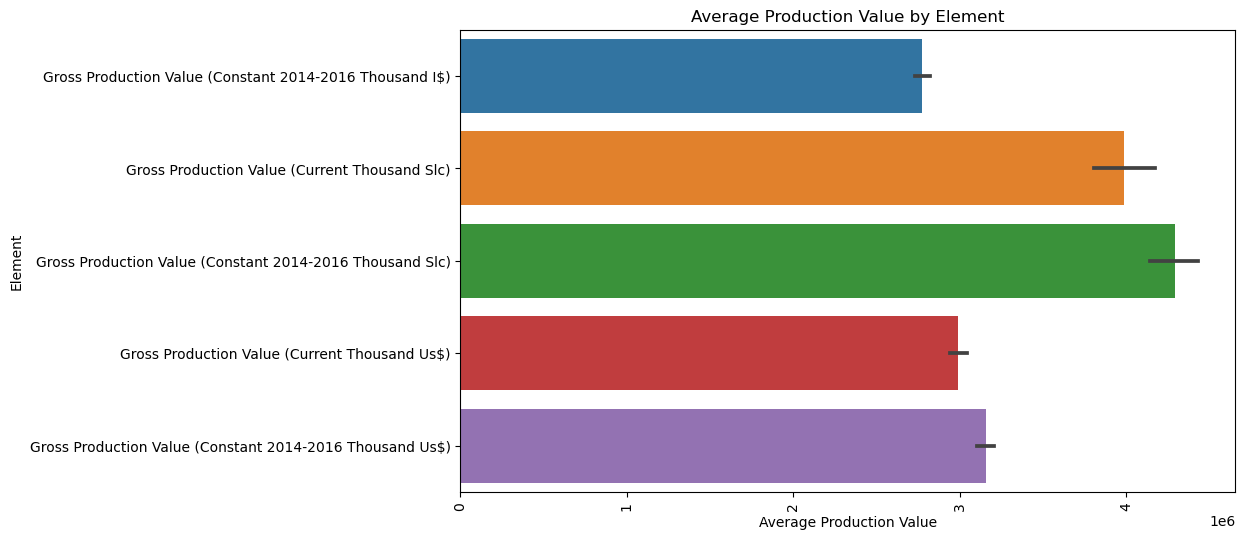

In [9]:
# Bar Plot of Average Production Value by Element
plt.figure(figsize=(10, 6))
sns.barplot(data=joined_data, x='Production_Value', y='ELEMENT')
plt.title('Average Production Value by Element')
plt.ylabel('Element')
plt.xlabel('Average Production Value')
plt.xticks(rotation=90)  # Rotate x-axis labels by 90 degrees
plt.show()

### Line plot for Time Series of Production Value Over Years

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


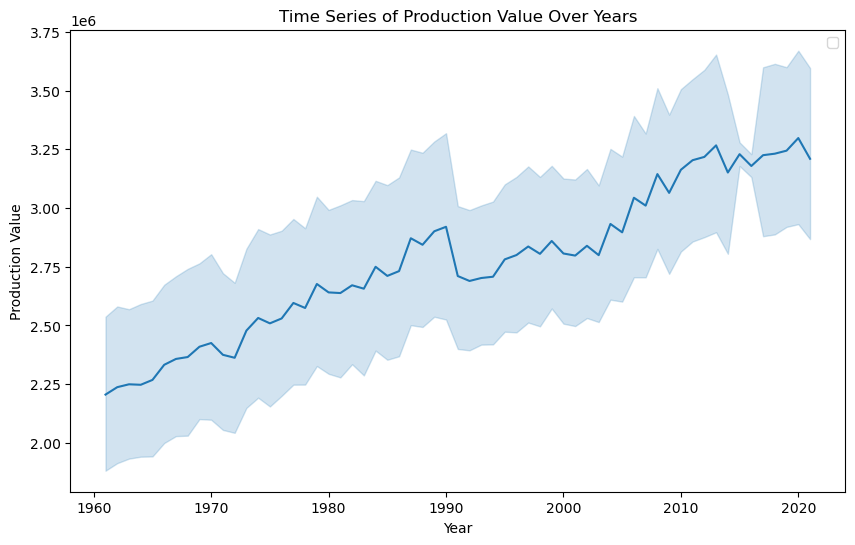

In [4]:
# Line plot for Time Series of Production Value Over Years
plt.figure(figsize=(10, 6))
sns.lineplot(data=joined_data, x='YEAR', y='Production_Value')
plt.title('Time Series of Production Value Over Years')
plt.xlabel('Year')
plt.ylabel('Production Value')
plt.legend()
plt.show()

### Pair Plot of Production Value and Other Variables

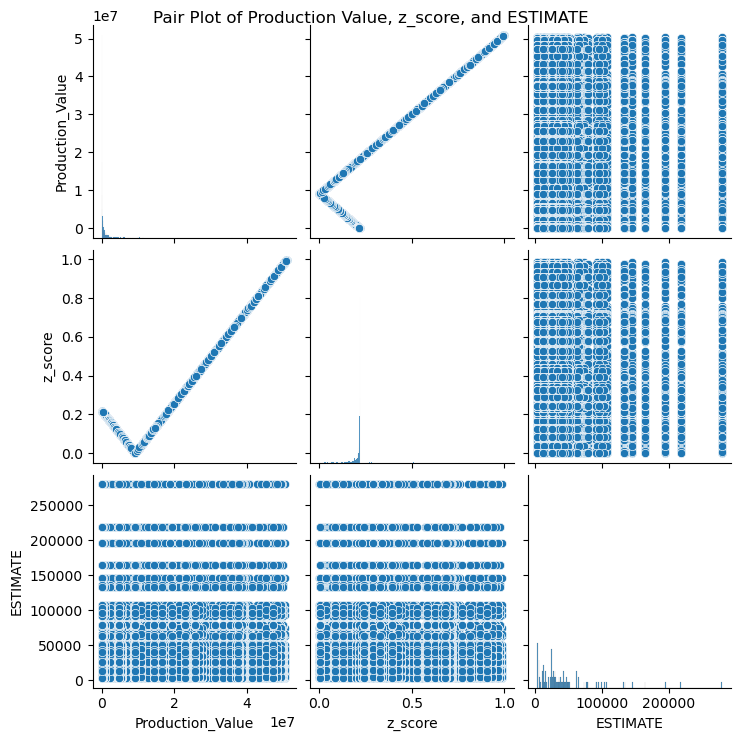

In [8]:
# Pair Plot of Production Value and Other Variables
sns.pairplot(data=joined_data, vars=['Production_Value', 'z_score', 'ESTIMATE'])
plt.suptitle('Pair Plot of Production Value, z_score, and ESTIMATE')
plt.show()

# Conclusion

In this project, we learned how to manipulate and analyze data using various Python libraries such as pandas, numpy, and seaborn and how to interact with SQLite databases and fetch data from APIs, website and flat files. The project involved several steps: data preprocessing, cleaning, merging and joining datasets, and creating visualizations. We also encountered and addressed issues related to data quality, consistency, and missing values.

To complete the project, performed the following essential tasks:
1. __Data Preprocessing__: Loaded flat files, web and fetch from API's into pandas DataFrames, filtered and renamed columns, and formatted data for better readability.
2. __Data Cleaning__: Identified and dealt with missing values by filtering out rows with missing data and dropping columns with a high percentage of missing values. Also calculated z-scores and filtered out outliers from the dataset.
3. __Data Transformation__: Standardized textual values, addressed issues with inconsistent casing, and performed replacements and cleanup operations on values within specific columns. This step aimed to ensure uniformity, accuracy, and reliability in the dataset, promoting more meaningful analysis and visualization.
4. __Data Integration__: Combined and integrated various data frames by utilizing relevant columns as identifiers, resulting in a unified dataset. This process required managing diverse datasets with distinct structures and column arrangements, enabling a comprehensive and coherent dataset for further analysis.
5. __Data Visualization__:  Utilizing the Matplotlib and Seaborn libraries generated a variety of visual representations. These visualizations were crucial in gaining deeper insights into the data's trends, correlations, and distributions. These graphical representations made the data's patterns and relationships more accessible and comprehensible, enabling effective communication of findings.
6. __Ethical Implications__: Data cleansing and analysis come with ethical considerations, especially when dealing with sensitive or personal information. In this project, we worked with agricultural production data, which might affect food security, environmental sustainability, and economic stability. Ethical considerations include ensuring data privacy, accuracy, transparency, avoiding bias and fair interpretation, and balanced presentation in analysis. By upholding these ethical principles, data professionals contribute to more responsible and informed decision-making while fostering trust and integrity.

In summary, this project offered practical exposure to critical data science aspects, encompassing data preprocessing, cleaning, analysis, and visualization. The integration of ethical considerations was evident in agricultural production data, underscoring the need for accurate, transparent, and unbiased analysis. The project's holistic approach reinforced that ethical data handling and thorough analysis form the bedrock of informed decision-making, particularly when addressing critical sectors such as agriculture, the economy, and the environment.